In [118]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

## Task 2

In [119]:
# Load data
dfTrainData = pd.read_csv("./../TrainData.csv")
dfTrainData

,TIMESTAMP,POWER,U10,V10,WS10,U100,V100,WS100
0,20120101 1:00,0.273678,0.534894,-3.660243,3.699120,0.765355,-4.486657,4.551468
1,20120101 2:00,0.086796,0.330813,-2.676430,2.696797,0.469875,-3.213752,3.247920
2,20120101 3:00,0.006811,-0.065839,-2.029072,2.030140,-0.020893,-2.418119,2.418209
3,20120101 4:00,0.018646,-0.419549,-1.799090,1.847362,-0.444867,-2.149654,2.195203
4,20120101 5:00,0.034812,-0.754224,-1.661526,1.824698,-0.838274,-1.991829,2.161038
...,...,...,...,...,...,...,...,...
16075,20131031 20:00,0.101254,-1.459917,-1.778960,2.301316,-1.974368,-4.936280,5.316483
16076,20131031 21:00,0.105047,-1.293326,-2.350447,2.682777,-0.781394,-4.903565,4.965433
16077,20131031 22:00,0.145079,-0.308284,-2.441885,2.461269,0.257905,-4.027432,4.035681
16078,20131031 23:00,0.180933,1.148765,-2.789011,3.016330,1.628004,-3.520358,3.878572


In [120]:
# Limit use of wind speed at 10m above ground level
dfTrainData = dfTrainData.drop(columns=['U100', 'V100', 'WS100'])

# WeatherForecastInput df
dfWFI = pd.read_csv("./../WeatherForecastInput.csv")
dfWFI = dfWFI.drop(columns=['U100', 'V100', 'WS100'])

In [121]:
# Use only data from November 2012
dfTrainData = dfTrainData[dfTrainData['TIMESTAMP'].str.contains('201211')]
dfTrainData

,TIMESTAMP,POWER,U10,V10,WS10
7319,20121101 0:00,0.540716,1.462973,5.899795,6.078476
7320,20121101 1:00,0.532988,1.462894,5.920271,6.098333
7321,20121101 2:00,0.472700,1.402827,5.724644,5.894020
7322,20121101 3:00,0.402259,1.580299,5.599491,5.818216
7323,20121101 4:00,0.340247,1.381530,5.542989,5.712561
...,...,...,...,...,...
8034,20121130 19:00,0.118238,2.752654,3.001374,4.072511
8035,20121130 20:00,0.102369,2.371182,3.555976,4.274046
8036,20121130 21:00,0.017541,1.952320,3.780458,4.254811
8037,20121130 22:00,0.055956,1.885940,3.359458,3.852626


In [122]:
# Calculate the wind direction based on the zonal component U10 and meridional component V10
# U10: Zonal component of the wind forecast (West-East projection)
# V10: Meridional component of the wind forecast (South-North projection)
# WD10: Wind Direction component

# Calculate WD10 in TrainData DataFrame
WD10_values = []
for index, row in dfTrainData.iterrows():
    # WD10 = np.arctan2(V10, -U10)
    WD10_values.append(np.arctan2(row['U10'], -(row['V10'])))
dfTrainData['WD10'] = WD10_values

# Calculate WD10 in WeatherForecastInput DataFrame
WD10_WFI_values = []
for index, row in dfWFI.iterrows():
    # WD10 = np.arctan2(V10, -U10)
    WD10_WFI_values.append(np.arctan2(row['U10'], -(row['V10'])))
dfWFI['WD10'] = WD10_WFI_values
dfWFI

,TIMESTAMP,U10,V10,WS10,WD10
0,20131101 1:00,3.462251,-1.066374,3.622753,1.272016
1,20131101 2:00,3.651341,-0.337717,3.666925,1.478568
2,20131101 3:00,3.657829,0.328049,3.672510,1.660241
3,20131101 4:00,3.551698,0.735371,3.627028,1.774959
4,20131101 5:00,3.586921,1.050811,3.737673,1.855779
...,...,...,...,...,...
715,20131130 20:00,-2.527419,-6.623859,7.089666,-0.364512
716,20131130 21:00,-2.529020,-7.423845,7.842794,-0.328332
717,20131130 22:00,-3.105103,-6.653005,7.341943,-0.436673
718,20131130 23:00,-2.286417,-6.165074,6.575396,-0.355142


In [123]:
""" Multiple Linear Regression (MVR) """
# Build a Multiple Linear Regression (MLR) model between wind power generation and two weather parameters (wind speed and wind direction)
# POWER: Measured power values (normalized)
# WS10: Wind Speed at 10m above ground level

# Separate features and target variable
X_train = dfTrainData[['WS10', 'WD10']]
y_train = dfTrainData['POWER']

# Predict the wind power production for the whole month 11.2013 based on the MLR model and weather data in WeatherForecastInput.csv
X_test = dfWFI[['WS10', 'WD10']]

# Train the Multiple Linear Regression model
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

# Prediction
y_pred = LR_model.predict(X_test)
dfWFI.insert(1, 'POWER', y_pred)

# Evaluate the model
dfSolution = pd.read_csv("./../Solution.csv")
print('Root mean squared error (RMSE):', np.sqrt(mean_squared_error(dfSolution['POWER'], y_pred)))

Root mean squared error (RMSE): 0.21385860697296014


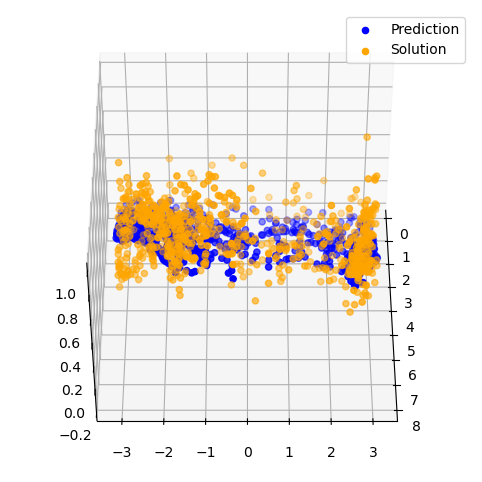

In [124]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection ='3d')
ax.scatter(dfWFI['WS10'] , dfWFI['WD10'], y_pred, label ='Prediction', color = 'b')
ax.scatter(dfWFI['WS10'] , dfWFI['WD10'], dfSolution['POWER'], label ='Solution', color = 'orange')
ax.legend()
ax.view_init(45, 0)
plt.show()

In [125]:
# The predicted wind power production is saved in the file ForecastTemplate2.csv
pred_df = pd.DataFrame({'TIMESTAMP': dfWFI['TIMESTAMP'], 'POWER': y_pred})
pred_df.to_csv('./../ForecastTemplate/ForecastTemplate2.csv', index=False)